# Supervised Mixture Models for Population Health

This colab notebook accompanies the research paper by Xiao Shou et al. of the same name.

In [0]:
!pip install https://github.com/TheRensselaerIDEA/ExplainableAI/blob/master/dist/ExplainableAI-0.0.1-py3-none-any.whl?raw=true
!pip install -r https://raw.githubusercontent.com/TheRensselaerIDEA/ExplainableAI/master/requirements.txt

In [0]:
from explainableAI.models import SupervisedBMM, SupervisedGMM
from explainableAI.metrics import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster,sgmmResults
from explainableAI.models.mlModels import *
from explainableAI.metrics.utility import entropy,asymm_entropy
from explainableAI.metrics.ftest_logodds import ftest_uncorr, restest
from explainableAI.visual.clustmap import plotclustmap
from google.colab import files
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import time
from urllib.request import urlretrieve
from zipfile import ZipFile

# SPARCS Data

[SPARCS](https://www.health.ny.gov/statistics/sparcs/) is a comprehensive all payer data reporting system established in 1979 as a result of cooperation between the healthcare industry and government. The system was initially created to collect information on discharges from hospitals. SPARCS currently collects patient level detail on patient characteristics, diagnoses and treatments, services, and charges for each hospital inpatient stay and outpatient (ambulatory surgery, emergency department, and outpatient services) visit; and each ambulatory surgery and outpatient services visit to a hospital extension clinic and diagnostic and treatment center licensed to provide ambulatory surgery services.


# Data Preparation

We extracted 2.34 million Medicaid records describing inpatient hospital encounters, derived from the publicly available 2016 SPARCS data. Each encounter was described by 38 features. This notebook works with "Newborn" encounters, one of 3 subsets of the data (Newborn, CircSyst, and Pregnancy). 

In [0]:
# Import/View Dataset

sparcs_df = pd.read_csv("https://github.com/TheRensselaerIDEA/ExplainableAI/blob/master/Data/sparcs25%25Newborn_DeHos_Outflow_Region.csv?raw=true")
sparcs_df.head()

,New_York_City,Hudson_Valley,Long_Island,Capital_Adiron,Central_NY,Southern_Tier,Western_NY,Finger_Lakes,Albany,Allegany,Bronx,Broome,Cattaraugus,Cayuga,Chautauqua,Chemung,Chenango,Clinton,Columbia,Cortland,Dutchess,Erie,Franklin,Fulton,Genesee,Jefferson,Kings,Lewis,Livingston,Madison,Manhattan,Monroe,Montgomery,Nassau,Niagara,Oneida,Onondaga,Ontario,Orange,Oswego,...,CCS_PROC_OT_OR_THER_PRC_ON_JOINT,CCS_PROC_OT_OR_THER_PRC_SKN_BRST,CCS_PROC_OT_OR_THER_PRC__FEM_ORG,CCS_PROC_OT_OR_THER_PRCS_ON_BONE,CCS_PROC_OT_OR_THER_PRCS_URINARY,CCS_PROC_OT_OR_THER_PRCS__MALE,CCS_PROC_OT_OR_UP_GI_THER_PRCS,CCS_PROC_OT_PHYS_THER_REHAB,CCS_PROC_OT_THER_PRCS_ON_MUSCLES,CCS_PROC_OT_THER_PRCS__HEM_LYMPH,CCS_PROC_OT_THERAPEUTIC_EAR_PRCS,CCS_PROC_OT_VASC_CATH__NOT_HEART,CCS_PROC_OT_VASCULAR_BYP_SHUNT,CCS_PROC_OTHER_BOWEL_DX_PRCS,CCS_PROC_OTHER_DX_NERV_SYS_PRCS,CCS_PROC_OTHER_DX_ULTRASOUND,CCS_PROC_OTHER_GI_DX_PRCS,CCS_PROC_OTHER_HERNIA_REPAIR,CCS_PROC_OTHER_OR_HEART_PRCS,CCS_PROC_OTHER_OR_THER_NERV_SYS,CCS_PROC_OTHER_OR_THER_PRCS_NOSE,CCS_PROC_OTHER_RESP_THERAPY,CCS_PROC_OTHER_THERAPEUTIC_PRCS,CCS_PROC_PHYS_THER_EXER_MANIPUL,CCS_PROC_PRCS_ON_THE_URETHRA,CCS_PROC_PROCTOSCOPY_and_AR_BIOPSY,CCS_PROC_PROPHYLACTIC_VAC_INOCUL,CCS_PROC_RESP_INTUB_MECH_VENTIL,CCS_PROC_ROUTINE_CHEST_X_RAY,CCS_PROC_SKIN_GRAFT,CCS_PROC_SMALL_BOWEL_RESECTON,CCS_PROC_SUTURE_SKIN_SUBCUT_TISS,CCS_PROC_SWAN_GANZ_CATH_MONITOR,CCS_PROC_TRACHE__LARYNG_OSCOPY,CCS_PROC_TRACHEOSTOMY__TEMP_PERM,CCS_PROC_TRACTN_SPLNT_OT_WOUND,CCS_PROC_TRTMNTFACE_FRACT_DISLC,CCS_PROC_TRTMNTFRAC_LOWR_EXTREM,CCS_PROC_UPPER_GI_X_RAY,Target
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Test/Train Split

d_newborn_tr, d_newborn_te = train_test_split(sparcs_df, test_size=0.2, random_state = 1512)
print("Train Shape: ", d_newborn_tr.shape)
print("Test Shape: ", d_newborn_te.shape)

Train Shape:  (93543, 260)
Test Shape:  (23386, 260)


In [0]:
# Split categorical and response variables

Xtrain, Xtest = d_newborn_tr.values[:,0:-1], d_newborn_te.values[:,0:-1]
ytrain, ytest = d_newborn_tr.values[:,-1].astype(int), d_newborn_te.values[:,-1].astype(int)

In [0]:
# Metrics Columns
columns = ['cluster', 'size', 'high_cost%','low_cost%', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']

# Feature List
features = sparcs_df.columns[:-1]

In [0]:
# Split train into train/validation sets

train_df, val_df = train_test_split(d_newborn_tr, test_size = 0.2, random_state = 1512)
y_train_df, y_val_df = train_df.iloc[:,-1], val_df.iloc[:,-1]
print("Train Shape: ", train_df.shape)
print("Validation Shape: ", val_df.shape)

Train Shape:  (74834, 260)
Validation Shape:  (18709, 260)


# Pick k

Select 'k' based on AUC. The following cell runs our Supervised Bernoulli Mixture Model and Supervised Gaussian Mixture Model across cluster sizes 2-10 with 10 randomly generated seeds. 

<h2> <font color='red'>**Warning:** </font>  <b>The following 2 cells may take up to several hours. It is available for validaiton but not required for the rest of the notebook.<b> </h2>

## Validate K for SBMM 

In [0]:
#SET SBMM/SGMM PARAMETERS

max_iter = 30
max_iter2 = 30

train_np = train_df.values[:,0:-1]
val_np = val_df.values[:,0:-1]

y_train_np = y_train_df.values
y_val_np = y_val_df.values

test_re_B = []
train_re_B = []
seed_list_B = []

start = time.time()

for j in range(0,10): 

    seed_num = random.randint(0,100000)
    seed_list_B.append(seed_num)
    print("\n TRAINING WITH RANDOM SEED {}". format(seed_num))

    #test clusters 2-10
    for i in range(2,10):
        print("\n\n\nTRAINING WITH {} CLUSTERS".format(i))
        np.random.seed( seed = seed_num)
        modelB = SupervisedBMM(max_iter = max_iter, max_iter2 = max_iter2, n_clusters = i, solver="liblinear")
        modelB = modelB.fitB(Xtrain = train_np, Xtest=val_np, ytrain = y_train_np)

        logisRegre = modelB.LogRegr
        fitP = modelB.fitParams
        labTrainB  = fitP['labTrain']
        mTest = modelB.predict_BMMS(val_np)
        labTestB = np.argmax( mTest, axis = 1 )

        probTest, probTrain = modelB.predict_prob_int_B( Xtest = val_np, Xtrain = train_np )
        tau = optimalTau(probTrain, y_train_np)
        metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = y_val_np)
        metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = y_train_np)
        metTestSBMM = pd.DataFrame( [metTest], columns = columns)
        metTrainSBMM = pd.DataFrame( [metTrain], columns = columns)

        test_re_B.append( metTestSBMM )
        train_re_B.append( metTrainSBMM )
end = time.time() - start
print("time elapsed: {}".format( end ))


#PICK THE CLUSTERS

pdi = pd.DataFrame(np.zeros(shape = [len(test_re_B), test_re_B[0].shape[1]]), columns = columns)
pdi_tr = pd.DataFrame(np.zeros(shape = [len(train_re_B), train_re_B[0].shape[1]]), columns = columns)

for i, panda in enumerate(test_re_B):
     pdi.iloc[i,:] = panda.iloc[0,:]
        
for i, panda in enumerate(train_re_B):
     pdi_tr.iloc[i,:] = panda.iloc[0,:]

pdi['seed_number'] = pd.DataFrame(np.repeat(np.array(seed_list_B),9) )
pdi['cluster']= pd.DataFrame(np.tile(np.arange(2,10),10))

print('Here are the number of clusters and seed_number for the largest auc ')
print(pdi.sort_values(by = 'auc',ascending=False).iloc [0,:][['cluster','auc','seed_number']])
print('Here are the number of clusters and seed_number for the smallest auc ')
print(pdi.sort_values(by = 'auc',ascending=True).iloc [0,:][['cluster','auc','seed_number']])

## Validate K for SGMM

In [0]:
for j in range(0,10): 

    seed_num = random.randint(0,100000)
    seed_list.append(seed_num)
    print("\n TRAINING WITH RANDOM SEED {}". format(seed_num))
#test clusters 2-10
    for i in range(2,11):
        print("\n\n\nTRAINING WITH {} CLUSTERS".format(i))
        np.random.seed( seed = seed_num )
        model = SupervisedGMM(max_iter = max_iter, max_iter2 = max_iter2, n_clusters = i)
        model = model.fit(Xtrain = train_np, ytrain = y_train_np)
        probTrain = model.predict_proba( train_np )
        probTest = model.predict_proba( val_np )
        results = sgmmResults( model, probTest.copy(), probTrain.copy(), y_val_np.copy(), y_train_np.copy(), tau = None,
            mode = 0)
        testmetrics = results['testMet']
        trainMetrics = results[ 'trainMet']
        test_re.append( testmetrics )
        train_re.append( trainMetrics )
    
end = time.time() - start
print("time elapsed: {}".format( end ))

#PICK THE CLUSTERS

pdi = pd.DataFrame(np.zeros(shape = [len(test_re), test_re[0].shape[1]]), columns = columns)
pdi_tr = pd.DataFrame(np.zeros(shape = [len(train_re), train_re[0].shape[1]]), columns = columns)

for i, panda in enumerate(test_re):
     pdi.iloc[i,:] = panda.iloc[0,:]
        
for i, panda in enumerate(train_re):
     pdi_tr.iloc[i,:] = panda.iloc[0,:]

pdi['seed_number'] = pd.DataFrame(np.repeat(np.array(seed_list),9) )
pdi['cluster']= pd.DataFrame(np.tile(np.arange(2,11),10))


print('Here are the number of clusters and seed_number for the largest auc ')
print(pdi.sort_values(by = 'auc',ascending=False).iloc [0,:][['cluster','auc','seed_number']])
print('Here are the number of clusters and seed_number for the smallest auc ')
print(pdi.sort_values(by = 'auc',ascending=True).iloc [0,:][['cluster','auc','seed_number']])

print('BASED ON THAT WE PICK 7 CLUSTERS with seed = 21274')

# SBMM with 7 clusters

In [0]:
# Load pre-written model for SBMM
def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download("https://github.com/TheRensselaerIDEA/ExplainableAI/blob/master/test_models/SBMM_niter1_30_niter2_30_nclust_7_seed_71730_2.pkl?raw=true"
        ,"SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")
print("Download Complete")

Download file... SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl ...
File downloaded
Download Complete


In [0]:
np.random.seed( seed = 71730 )
pre_load = True # Set to false to manually train model

# train SBMM model with Log Regression
max_iter = 30
max_iter2 = 30
n_clusters = 7

if pre_load:
  modelB = SupervisedBMM.loader("SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")
  print("ModelB successfully loaded...")
else:
  modelB = SupervisedBMM( max_iter =max_iter, n_clusters = n_clusters, max_iter2 = max_iter2, verbose = 0, solver="liblinear")
  modelB = modelB.fitB( Xtrain = Xtrain, Xtest = Xtest, ytrain = ytrain)

mTrain = modelB.mTrain
logisRegre = modelB.LogRegr
fitP = modelB.fitParams
labTrainB  = fitP['labTrain']
mTest = modelB.predict_BMMS(Xtest)
labTestB = np.argmax( mTest, axis = 1 )

probTest, probTrain = modelB.predict_prob_int_B( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSBMM = pd.DataFrame( [metTest], columns = columns)
metTrainSBMM = pd.DataFrame( [metTrain], columns = columns)

metTrainSBc, metTestSBc = metrics_cluster(models = logisRegre, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestB,
                                        trainlabels = labTrainB,
                                        Xtrain = Xtrain, Xtest = Xtest)

ModelB successfully loaded...


In [0]:
# If you want to save current model locally
modelB.save("SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")
files.download("SBMM_niter1_30_niter2_30_nclust_7_seed_71730.pkl")

## Evaluation

We define the top-25th percentile as high cost, basedon guidance from Wammes et al. and NYSDOH. 

### Cadrewise Train

In [0]:
metTrainSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]]

,size,high_cost%,f1,auc
0,16045.0,0.11,0.66,0.89
1,8150.0,0.20,0.52,0.80
2,6531.0,0.22,0.60,0.86
3,17343.0,0.23,0.59,0.85
4,16718.0,0.26,0.57,0.78
5,26322.0,0.34,0.57,0.73
6,2434.0,0.53,0.84,0.91


### Cadrewise Test

In [0]:
metTestSBc.round(2).sort_values(by ='high_cost%').reset_index().iloc[:,np.r_[2:4,-2,-1]]

,size,high_cost%,f1,auc
0,4053.0,0.11,0.65,0.89
1,2087.0,0.20,0.52,0.80
2,1673.0,0.23,0.59,0.85
3,4205.0,0.23,0.58,0.84
4,4132.0,0.26,0.55,0.77
5,6674.0,0.33,0.55,0.72
6,562.0,0.50,0.81,0.89


### Cadre Cost vs Size Analysis

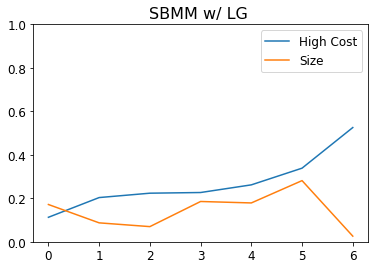

In [0]:
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y=sorted(metTrainSBc['high_cost%']))
sns.lineplot(x=np.arange(metTrainSBc.shape[0]), y= metTrainSBc.sort_values(by ='high_cost%')['size']/Xtrain.shape[0])
plt.title('SBMM w/ LG ',fontsize=16)
plt.xticks(range(n_clusters),fontsize=12)
plt.ylabel('')
plt.ylim(0,1)
plt.yticks(fontsize=12)
plt.legend(labels = ['High Cost','Size'],fontsize=12)
plt.show()

# Cost Groups: SBMM

In [0]:
# Cadre average high cost share statistics
target = pd.DataFrame(np.array([ytrain, labTrainB]).T,columns=['Target', 'Cadre'])
target["Size"] = 1
aggr_target = target.groupby("Cadre").agg({"Size": "sum",  "Target": "mean"})
print("Cadre average \"High Cost\" share statistics")
highcostratio = aggr_target["Target"].values
clustpop = aggr_target["Size"].values
Labels = labTrainB
aggr_target

Cadre average "High Cost" share statistics


,Size,Target
Cadre,,
0,6531,0.223549
1,16045,0.112745
2,16718,0.261873
3,2434,0.525472
4,8150,0.203436
5,17343,0.226662
6,26322,0.338652


In [0]:
print('Percent of high cost ratio by SBMM')
print(np.sort(highcostratio).round(2))
print()

print('Relative cadre size by SBMM')
print((clustpop/clustpop.sum())[np.argsort(highcostratio)].round(3))
print()

print('Log odds ratio for each cadre by SBMM')
print(restest(np.expand_dims(Labels,axis=1),
        np.expand_dims(target['Target'],axis=1))[np.argsort(highcostratio)].round(2))

Percent of high cost ratio by SBMM
[0.11 0.2  0.22 0.23 0.26 0.34 0.53]

Relative cadre size by SBMM
[0.172 0.087 0.07  0.185 0.179 0.281 0.026]

Log odds ratio for each cadre by SBMM
[-1.11 -0.29 -0.16 -0.16  0.07  0.62  1.24]


## The log odds ratio of high cost in different clusters


In [0]:
# Order labels
sortedLabels = np.argsort(highcostratio).tolist()
Labels2 = np.zeros(labTrainB.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( labTrainB == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2

In [0]:
# Range or list of indicies
categories = {
    "County": range(8,58),
    "Race": range(61,69),
    "Region": range(0,8),
    "Admission": range(75,80),
    "ER": range(70,72),
    "Disease1": range(80,113),
    "Disease2": range(113,142),
    "Procedure1": range(142,200),
    "Procedure2": range(200,259)
}

In [0]:
np_feat = np.asarray(features)
labs_binary = np.expand_dims(ytrain,axis=1)
feat_table_binary,lor_table_binary =ftest_uncorr(Xtrain,labs_binary,np_feat)
pd.DataFrame(lor_table_binary[:,categories["Race"]],columns = features[[categories["Race"]]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,Black_African_American,Multi_racial,Other_Race,White,Multi_Ethnic,Not_Span_Hispanic,Spanish_Hispanic,Unknown_Ethnicity
0,-0.144681,-0.594887,-0.325558,0.536927,-0.830452,-0.048132,-0.060539,0.329373
1,0.144681,0.594887,0.325558,-0.536927,0.830452,0.048132,0.060539,-0.329373


In [0]:
data = d_newborn_tr.iloc[:,:-1]
features = list(d_newborn_tr.iloc[:,:-1])
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

## Clean up feature text

In [0]:
# reduce feature length

new_feat = [s.replace('CCS_DX_' , '') for s in features]
new_feat = [s.replace('CCS_PROC_' , '') for s in new_feat]
new_feat = [s.replace('not_mental_disorders_or_infectious_disease','')for s in new_feat]
new_feat = [s.replace('birth weight; and','BW&')for s in new_feat]
new_feat = [s.replace('sexually_transmitted_disease','STD')for s in new_feat]
new_feat = [s.replace('tuberculosis','TB')for s in new_feat]
new_feat = [s.replace('system','syst')for s in new_feat]

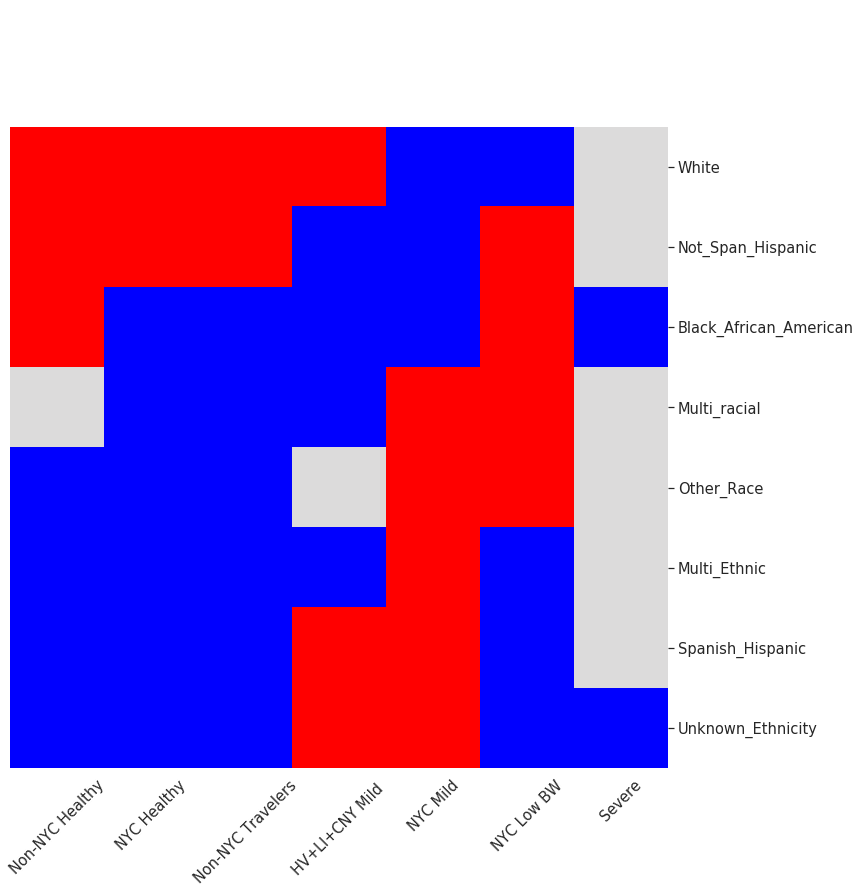

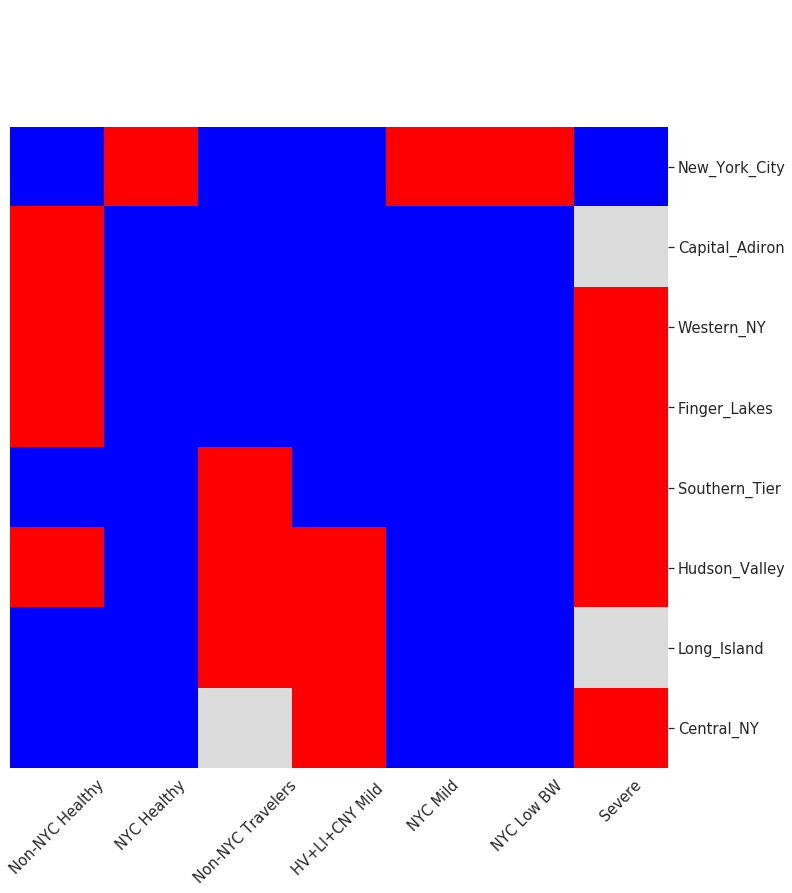

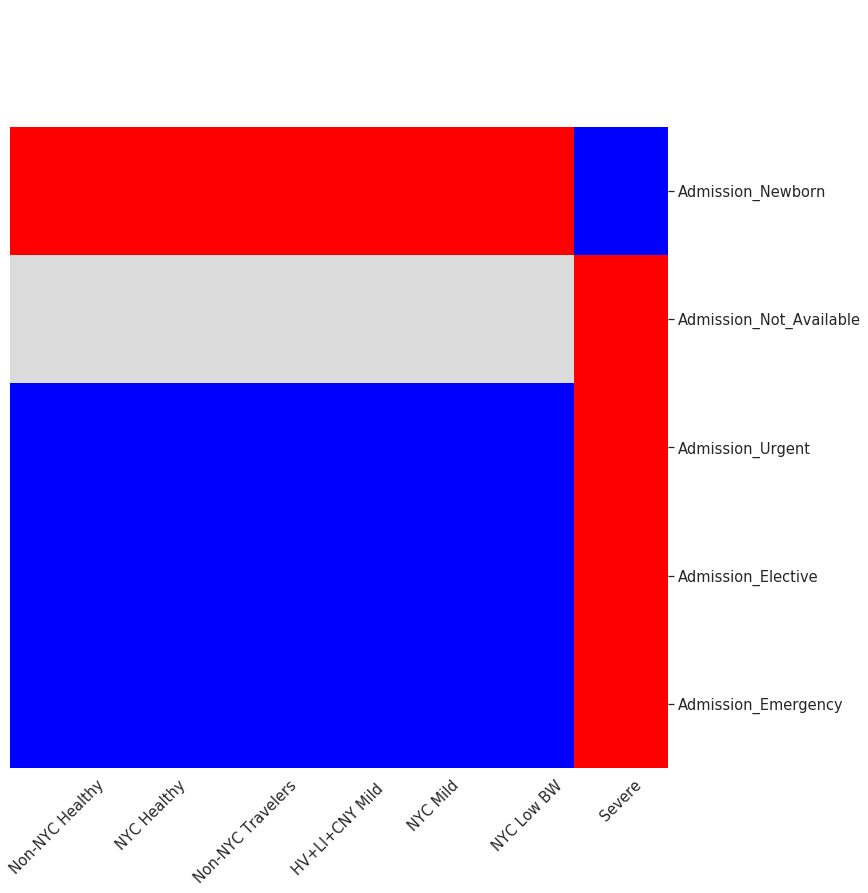

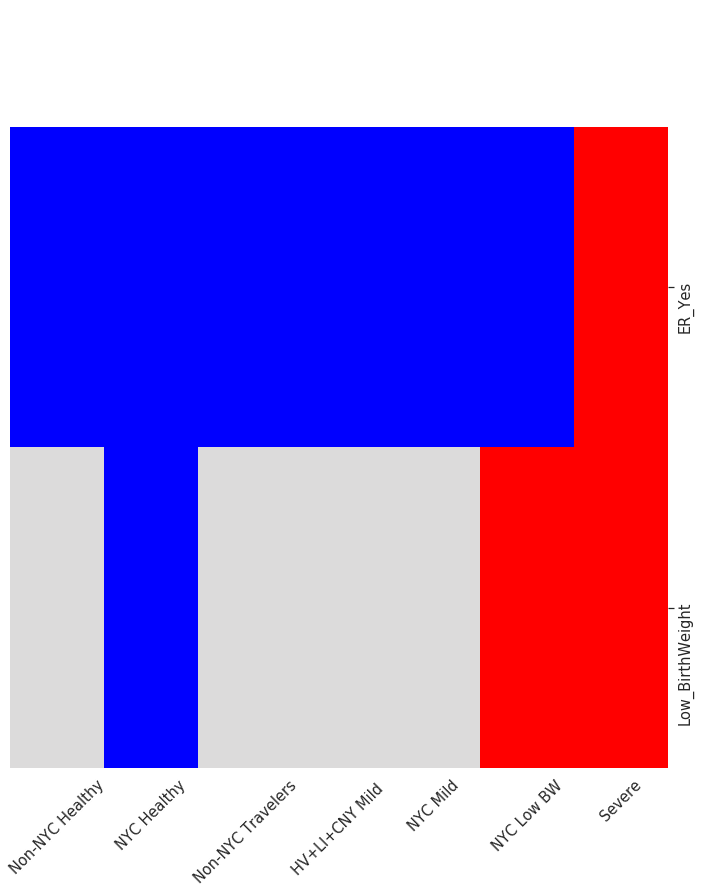

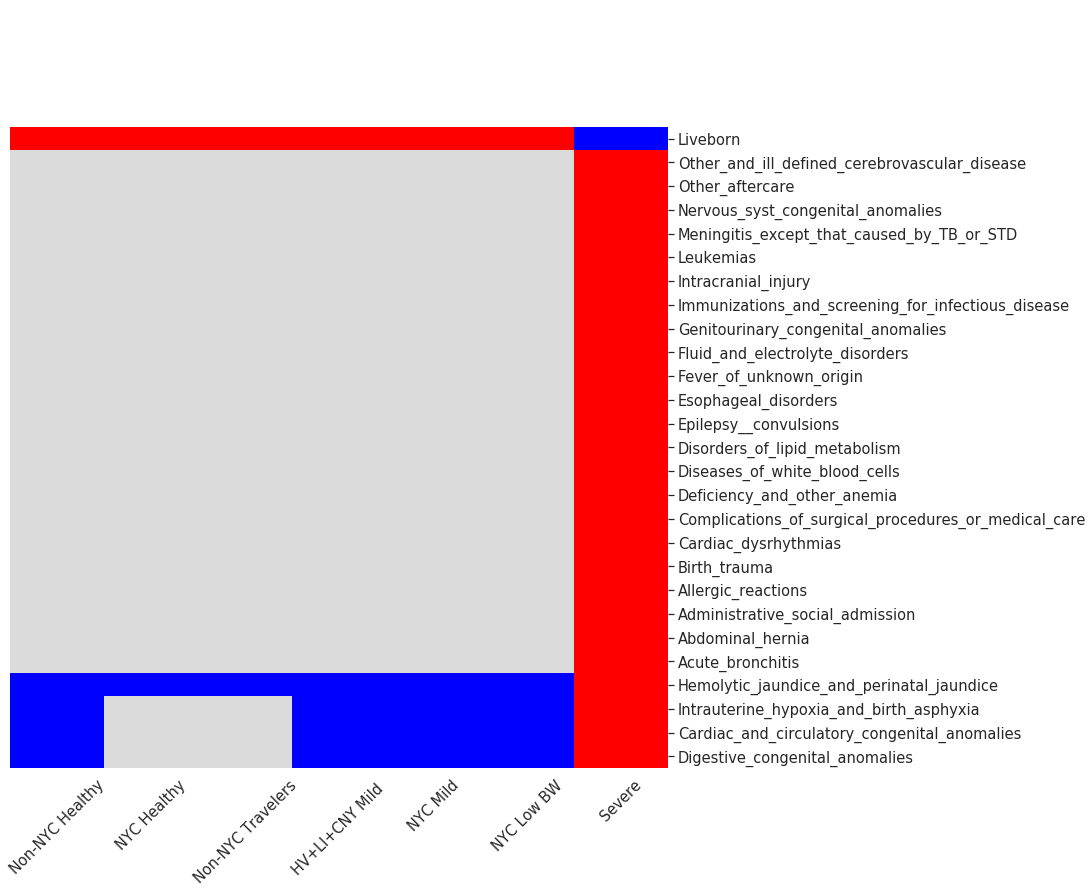

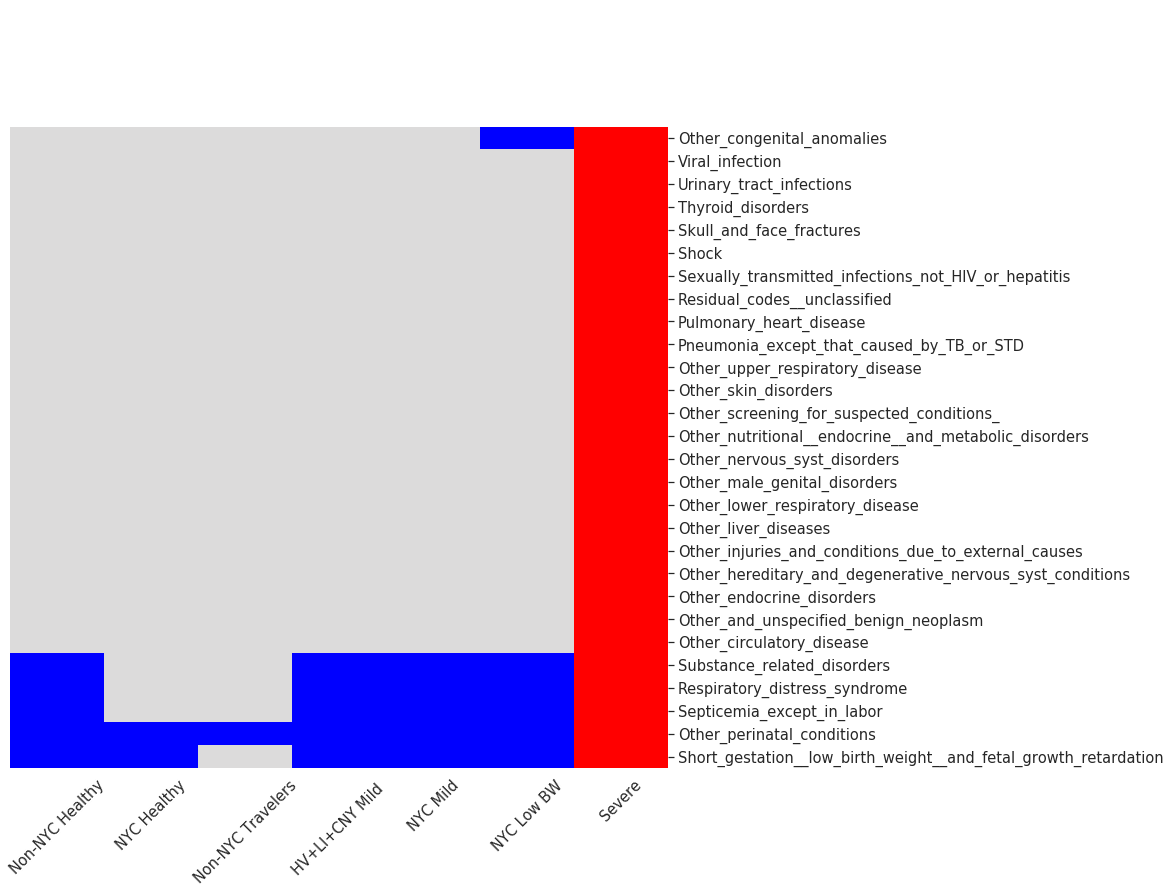

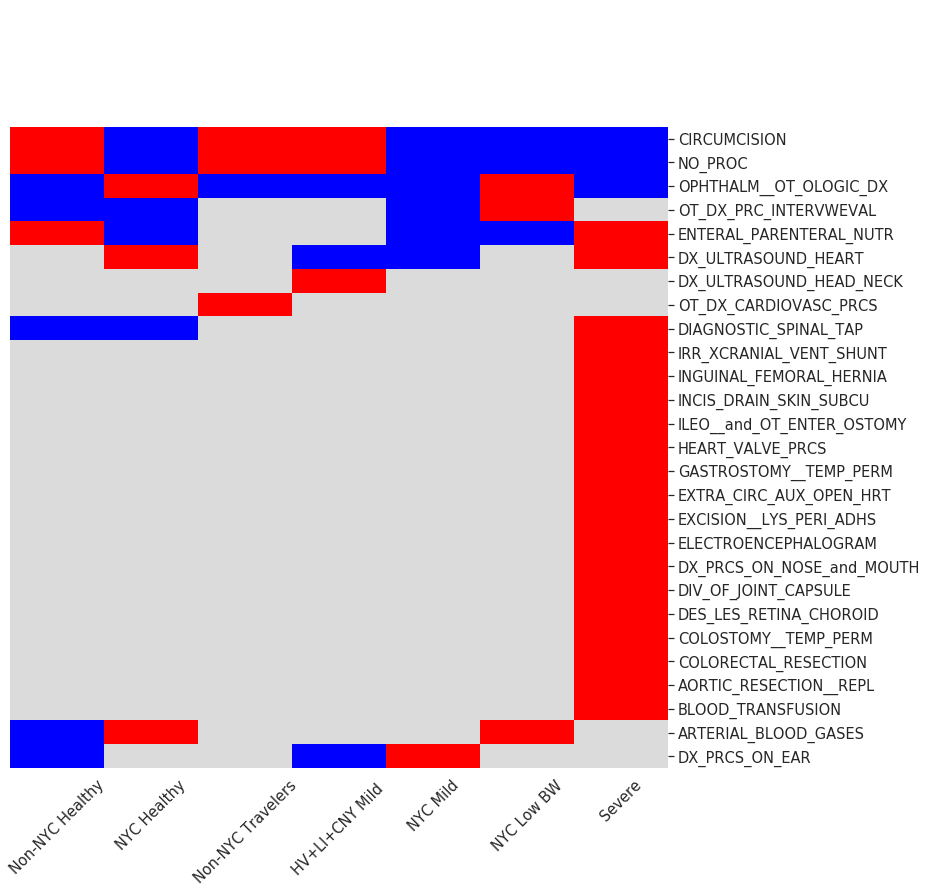

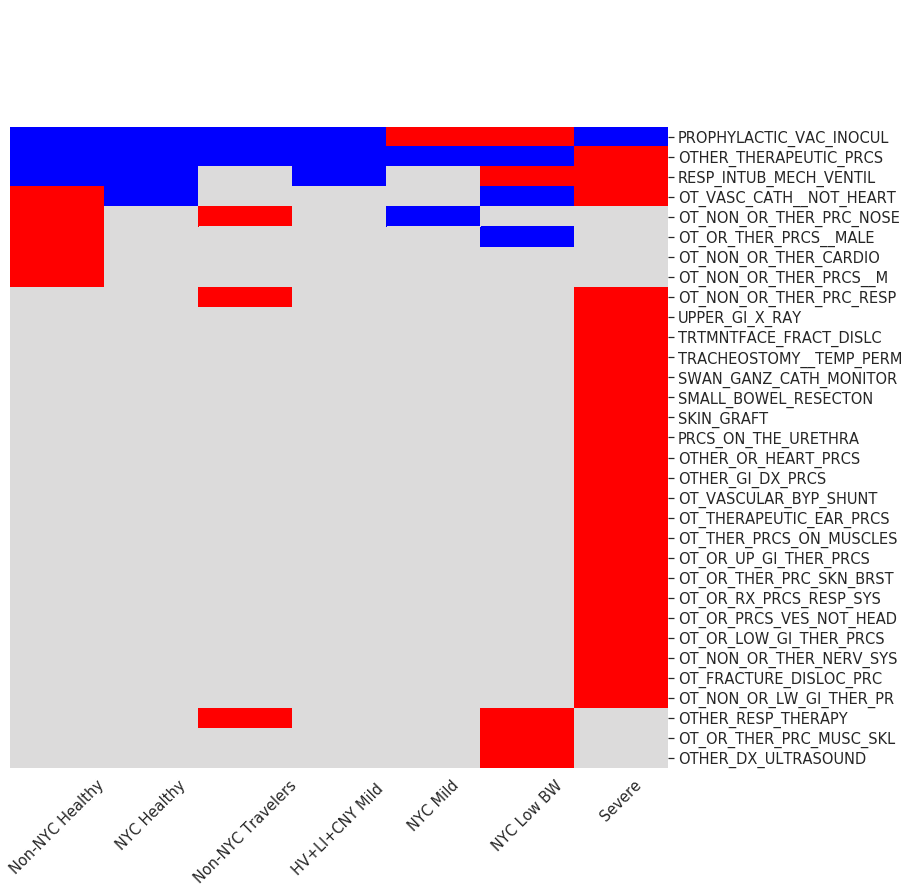

In [0]:
#Plot various categories
#TODO: Add rotation for better aesthetic

clustname = ['Non-NYC Healthy','NYC Healthy','Non-NYC Travelers','HV+LI+CNY Mild ','NYC Mild','NYC Low BW','Severe']

sns.set(font_scale=1.33)

mycmap = mpl.colors.LinearSegmentedColormap.from_list("", ["blue","gainsboro","red"])
for cat, val in categories.items():
  if cat == "County":
    continue
  if cat in {"Disease1", "Disease2", "Procedure1", "Procedure2"}:
    filter = np.sum(abs(feat_table[:,val]),axis=0)>0
  else:
    filter = np.ones(shape=feat_table[:,val].shape[1]).astype(bool)
  plotclustmap(feat_table[:,val][:,filter].T,
             None,np.array(new_feat)[val][filter],None,None, clustname, 
             cmap=mycmap)

# Cadre Weights

In [0]:
weights = np.array(modelB.weights)[:,1:]
sorted_weights = weights[np.argsort(aggr_target["Target"].values),:].T

In [0]:
# bootstraping for coefficients of cadres to be significantly nonzero
nBoot=1000

all_coefs = np.zeros((nBoot, n_clusters, len(features)))

for mm in range(n_clusters):
    data_m = d_newborn_tr[labTrainB==mm] 
    print("Cluster %d..." % mm)
    for b in range(nBoot):
        d_m_b = data_m.sample(frac=1, random_state=b, replace=True)
        log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=logisRegre[mm].best_params_['C'])
        log_reg.fit(d_m_b[features].values, d_m_b['Target'].values)
        all_coefs[b,mm,:] = np.squeeze(log_reg.coef_)

Cluster 0...
Cluster 1...
Cluster 2...
Cluster 3...
Cluster 4...
Cluster 5...
Cluster 6...


In [0]:
# estimate a nonzero coefficient with 99% confidence interval
quantiles = np.quantile(all_coefs, (0.005, 0.995), 0)
zero_status = np.zeros((len(features), n_clusters))

for mm in range(n_clusters):
    for p in range(len(features)):
        low_bound, up_bound = quantiles[:,mm,p]
        if low_bound > 0 or up_bound < 0:
            zero_status[p,mm] = 1
zero_status = pd.DataFrame(zero_status, index=features)
zero_status_order = zero_status[np.argsort(aggr_target["Target"].values)]

In [0]:
# make the weights positive, negative, and zero and only consider significant weights from bootstrapping
qualitative_weights = (sorted_weights < 0)*(-1) + (sorted_weights > 0)*1
filtered_weights = qualitative_weights*zero_status_order.values

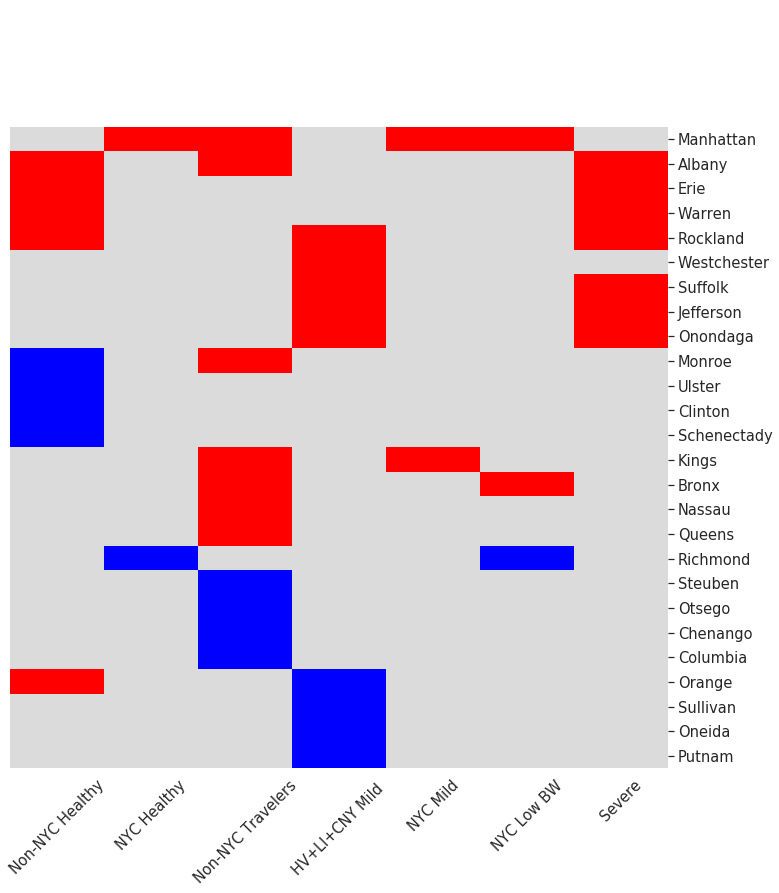

In [0]:
# county weights 
county_weights = filtered_weights[categories["County"],:]
# plot the clustermap of filtered  county weights 
county_w = plotclustmap((county_weights ) [np.sum(abs(county_weights),axis=1)>0,:], 
                        None, np.array(new_feat)[categories["County"]][np.sum(abs(county_weights),axis=1)>0],
                        None, None, clustname, cmap=mycmap)

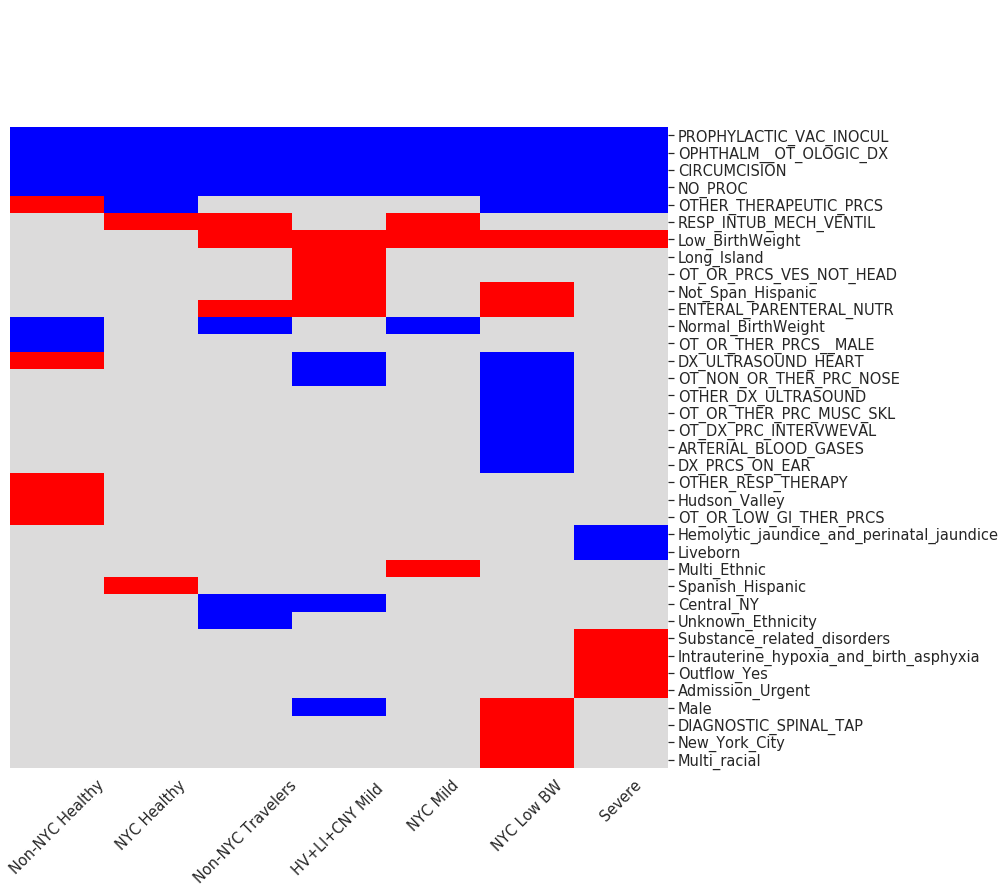

In [0]:
# noncounty weights 
noncounty_weights = filtered_weights[np.r_[0:8,58:259],:]
# plot the clustermap of filtered  noncounty weights 
general_w = plotclustmap((noncounty_weights ) [np.sum(abs(noncounty_weights),axis=1)>0,:], 
                         None, np.array(new_feat)[np.r_[0:8,58:259]][np.sum(abs(noncounty_weights),axis=1)>0], 
                         None, None, clustname, cmap=mycmap)

# SGMM with 7 clusters

In [0]:
# Load pre-written model for SGMM
def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download("https://github.com/TheRensselaerIDEA/ExplainableAI/blob/master/test_models/SGMM_niter1_30_niter2_30_nclust_7_seed_21274.pkl?raw=true"
      ,"SGMM_niter1_30_niter2_30_nclust_7_seed_21274.pkl")
print("Download Complete")

Download Complete


In [0]:
np.random.seed( seed = 21274 )
# train SGMM model with Log Regression
max_iter = 30
max_iter2 = 30
n_clusters = 7
pre_load = True

if pre_load:
  model = SupervisedBMM.loader("SGMM_niter1_30_niter2_30_nclust_7_seed_21274.pkl")
  print("Model successfully loaded...")
else:
  model = SupervisedGMM(max_iter=max_iter, max_iter2 = max_iter2, n_clusters = n_clusters, verbose = 0)
  model = model.fit(Xtrain = Xtrain, ytrain = ytrain)

# Retrieve memberships and labels
mTrainSGMM = model.mTrain
logisRegreSGMM = model.LogRegr
fitP = model.fitParams
labTrainSGMM  = fitP['labTrain']
mTestSGMM = model.predict_GMMS(Xtest)
labTestSGMM = np.argmax( mTestSGMM, axis = 1 )

# Summary of overall accuracy 
probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSGMM = pd.DataFrame( [metTest], columns = columns)
metTrainSGMM = pd.DataFrame( [metTrain], columns = columns)

# Cluster summary
metTrainSGc, metTestSGc = metrics_cluster(models = logisRegreSGMM, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestSGMM,
                                        trainlabels = labTrainSGMM,
                                        Xtrain = Xtrain, Xtest = Xtest)

Model successfully loaded...


In [0]:
# If you want to save current model
model.save("SGMM_niter1_30_niter2_30_nclust_7_seed_21274.pkl")
files.download("SGMM_niter1_30_niter2_30_nclust_7_seed_21274.pkl")

# Evaluation

## Cadrewise train

In [0]:
metTrainSGc.round(2).sort_values(by="high_cost%").reset_index().iloc[:,np.r_[2:4,-2,-1]]

,size,high_cost%,f1,auc
0,1524.0,0.14,0.71,0.94
1,1288.0,0.16,0.57,0.83
2,2244.0,0.20,0.88,0.99
3,86792.0,0.25,0.55,0.79
4,504.0,0.41,0.81,0.86
5,767.0,0.45,0.93,0.98
6,424.0,0.53,0.98,1.00


## Cadrewise Test

In [0]:
metTestSGc.round(2).sort_values(by="high_cost%").reset_index().iloc[:,np.r_[2:4,-2,-1]]

,size,high_cost%,f1,auc
0,367.0,0.14,0.78,0.97
1,311.0,0.16,0.56,0.77
2,540.0,0.19,0.92,0.99
3,21745.0,0.25,0.54,0.79
4,117.0,0.38,0.78,0.83
5,199.0,0.49,0.91,0.96
6,107.0,0.49,0.93,0.99


# Interpretability: SGMM

In [0]:
Labels = labTrainSGMM
target = pd.DataFrame(np.array([ytrain, Labels]).T,columns=['Target', 'Cadre'])
target["Size"] = 1
aggr_target = target.groupby("Cadre").agg({"Size": "sum",  "Target": "mean"})
print("Cadre average \"High Cost\" share statistics")
highcostratio = aggr_target["Target"].values
clustpop = aggr_target["Size"].values
aggr_target

Cadre average "High Cost" share statistics


,Size,Target
Cadre,,
0,504,0.410714
1,86792,0.251060
2,1288,0.156056
3,767,0.451108
4,1524,0.141076
5,2244,0.197861
6,424,0.533019


In [0]:
print('percent of high cost ratio by SGMM')
print(np.sort(highcostratio).round(2))
print('relative cadre size by SGMM')
print((clustpop/clustpop.sum())[np.argsort(highcostratio)].round(3))
print('Log odds ratio for each cadre by SGMM')
print(restest(np.expand_dims(Labels,axis=1),
        np.expand_dims(target['Target'],axis=1))[np.argsort(highcostratio)].round(2))

percent of high cost ratio by SGMM
[0.14 0.16 0.2  0.25 0.41 0.45 0.53]
relative cadre size by SGMM
[0.016 0.014 0.024 0.928 0.005 0.008 0.005]
Log odds ratio for each cadre by SGMM
[-0.72 -0.59 -0.31  0.04  0.74  0.91  1.24]


In [0]:
# Order labels
sortedLabels = np.argsort( highcostratio ).tolist()
Labels2 = np.zeros( Labels.shape)-1
index = 0

for sortedNumber in sortedLabels:
    inNumber = np.where( Labels == sortedNumber)[0]
    Labels2[inNumber] = index
    index += 1
Labels = Labels2

In [0]:
# Calculate log odds ratios for feature vs. target (whether or not is high cost)
target_binary = d_newborn_tr.iloc[:,-1]
data = d_newborn_tr.iloc[:,:-1]
np_feat = np.asarray(features)
labs_binary = np.expand_dims(target_binary,axis=1)
feat_table_binary,lor_table_binary =ftest_uncorr(data,labs_binary,np_feat)

In [0]:
# just show log odds ratio for race and ethnicity features : 0 lowcost, 1 high cost
pd.DataFrame(lor_table_binary[:,categories["Race"]],columns = np.array(features)[[categories["Race"]]]).round(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


,Black_African_American,Multi_racial,Other_Race,White,Multi_Ethnic,Not_Span_Hispanic,Spanish_Hispanic,Unknown_Ethnicity
0,-0.14,-0.59,-0.33,0.54,-0.83,-0.05,-0.06,0.33
1,0.14,0.59,0.33,-0.54,0.83,0.05,0.06,-0.33


In [0]:
# Calculate log odds ratios for feature vs. cadre 
labs = np.expand_dims(Labels,axis=1)
feat_table,lor_table =ftest_uncorr(data,labs,np_feat)

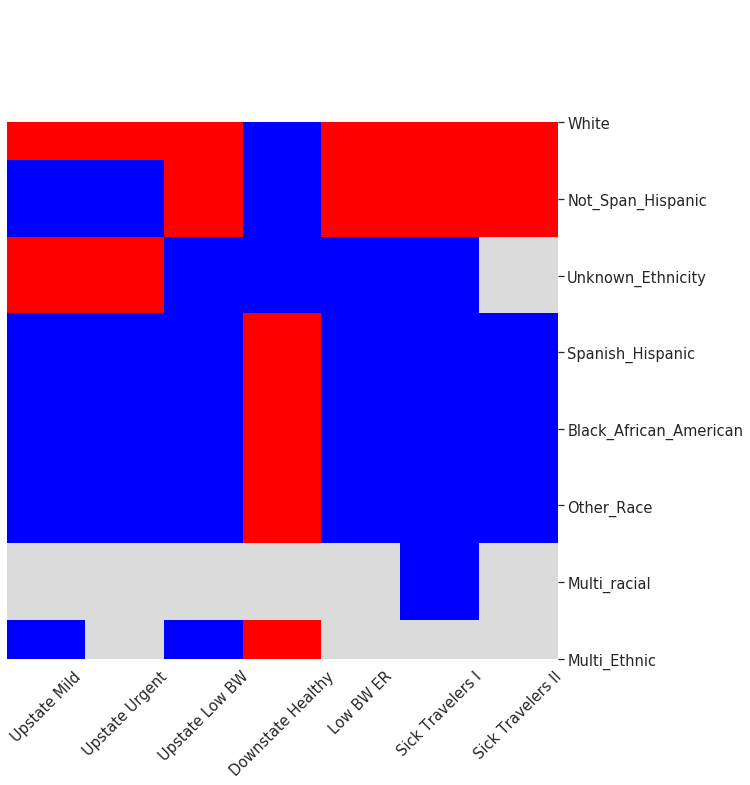

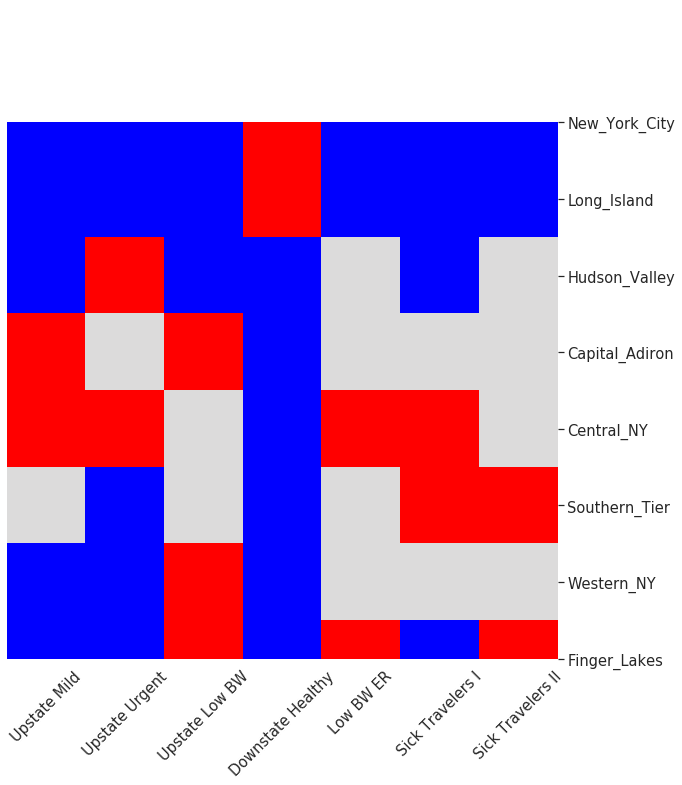

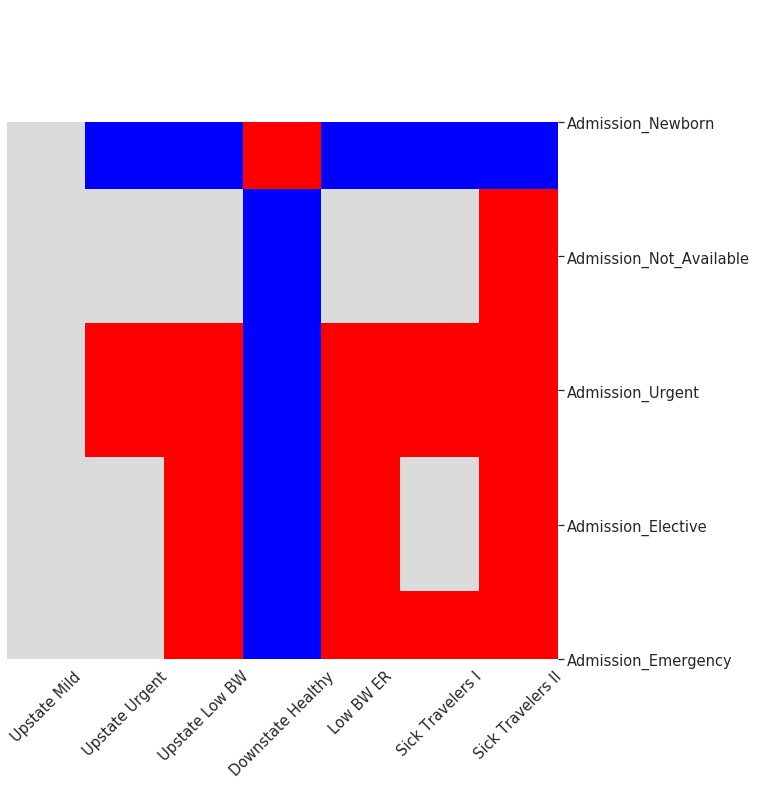

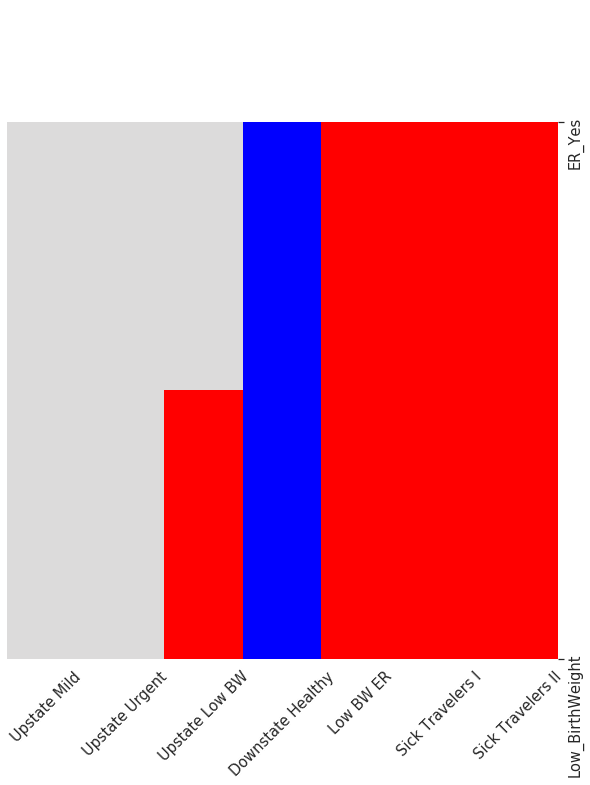

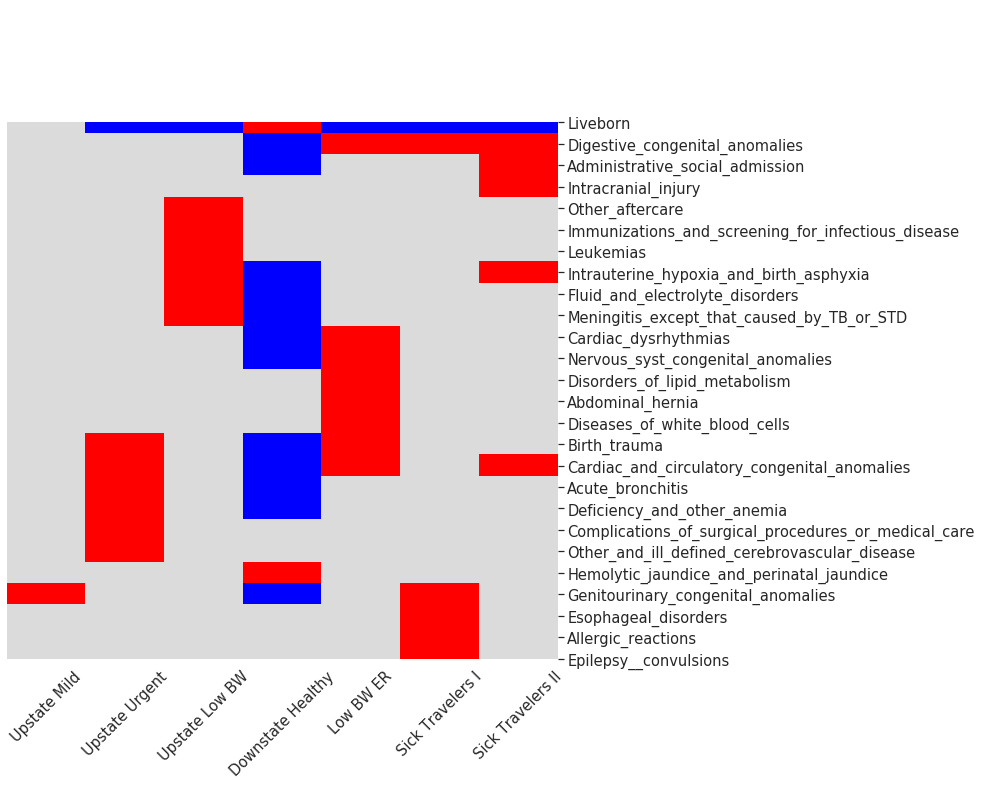

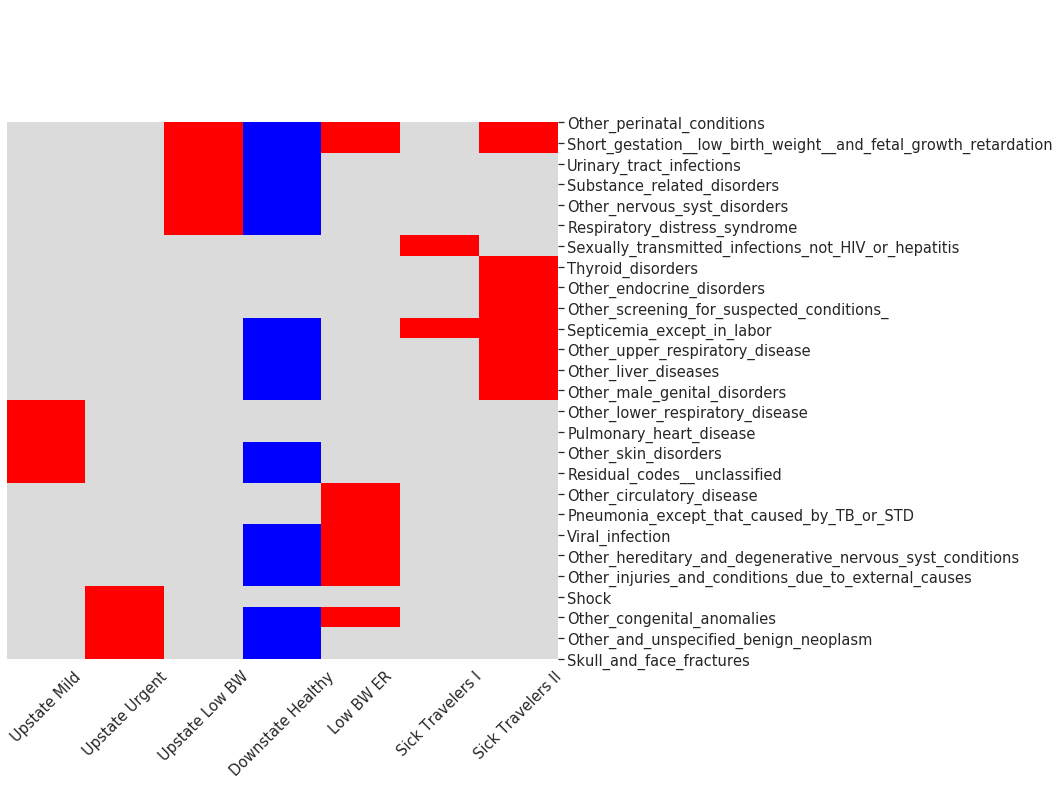

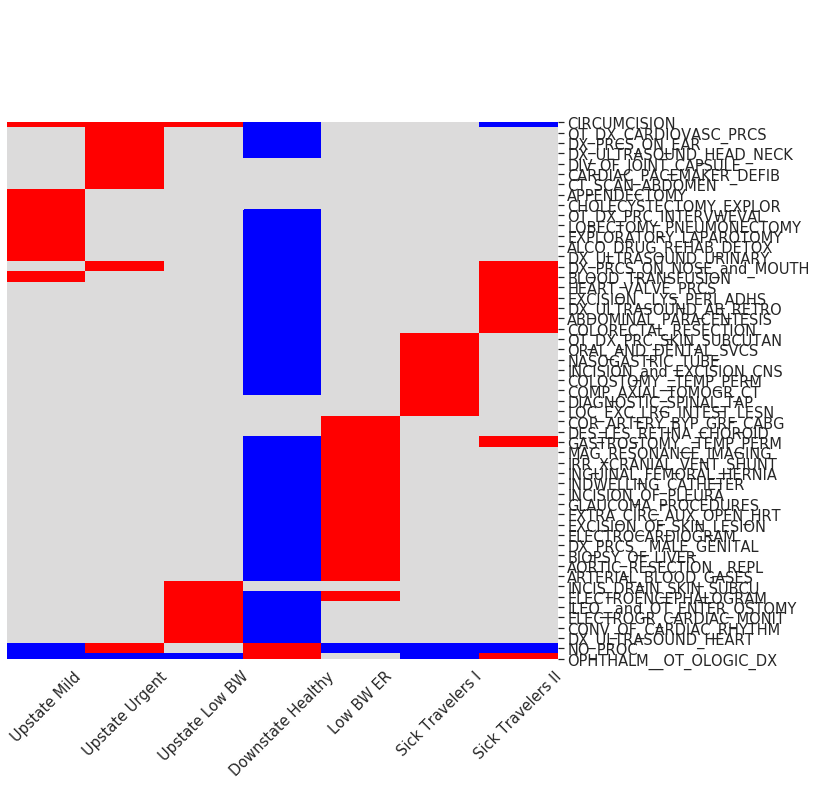

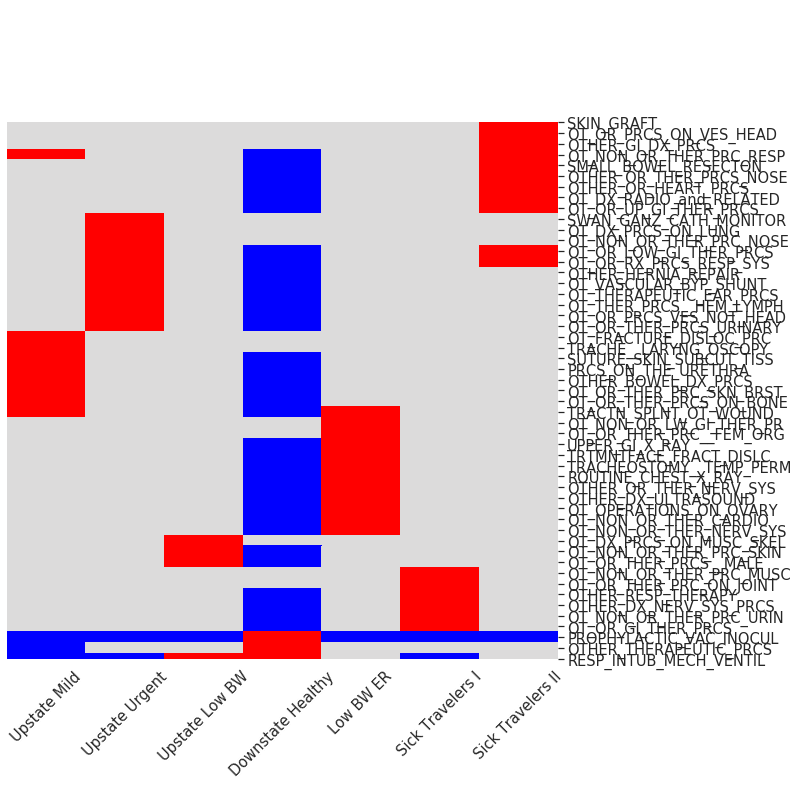

In [0]:
clustname = ['Upstate Mild','Upstate Urgent','Upstate Low BW','Downstate Healthy','Low BW ER','Sick Travelers I','Sick Travelers II']

for cat, val in categories.items():
  if cat == "County":
    continue
  if cat in {"Disease1", "Disease2", "Procedure1", "Procedure2"}:
    filter = np.sum(abs(feat_table[:,val]),axis=0)>0
  else:
    filter = np.ones(shape=feat_table[:,val].shape[1]).astype(bool)
  plotclustmap(feat_table[:,val][:,filter].T,
             None,np.array(new_feat)[val][filter],None,None, clustname, 
             cmap=mycmap)

## Cadre Weights and Predictability

In [0]:
# extract cadre weights
weights = np.array(model.weights)[:,1:]
sorted_weights = weights[np.argsort( highcostratio ),:].T

In [0]:
# bootstraping for coefficients of cadres to be significantly nonzero
nBoot=1000

all_coefs = np.zeros((nBoot, n_clusters, len(features)))

for mm in range(n_clusters):
    data_m = d_newborn_tr[labTrainSGMM==mm] 
    print("Cluster %d..." % mm)
    for b in range(nBoot):
        d_m_b = data_m.sample(frac=1, random_state=b, replace=True)
        log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=logisRegreSGMM[mm].best_params_['C'])
        log_reg.fit(d_m_b[features].values, d_m_b['Target'].values)
        all_coefs[b,mm,:] = np.squeeze(log_reg.coef_)

Cluster 0...
Cluster 1...
Cluster 2...
Cluster 3...
Cluster 4...
Cluster 5...
Cluster 6...


In [0]:
# estimate a nonzero coefficient with 99% confidence interval
quantiles = np.quantile(all_coefs, (0.005, 0.995), 0)
zero_status = np.zeros((len(features), n_clusters))

for mm in range(n_clusters):
    for p in range(len(features)):
        low_bound, up_bound = quantiles[:,mm,p]
        if low_bound > 0 or up_bound < 0:
            zero_status[p,mm] = 1
zero_status = pd.DataFrame(zero_status, index=features)
zero_status_order = zero_status[np.argsort( highcostratio )]

In [0]:
# make the weights positive, negative, and zero and only consider significant weights from bootstrapping
qualitative_weights = (sorted_weights < 0)*(-1) + (sorted_weights > 0)*1
filtered_weights = qualitative_weights*zero_status_order.values

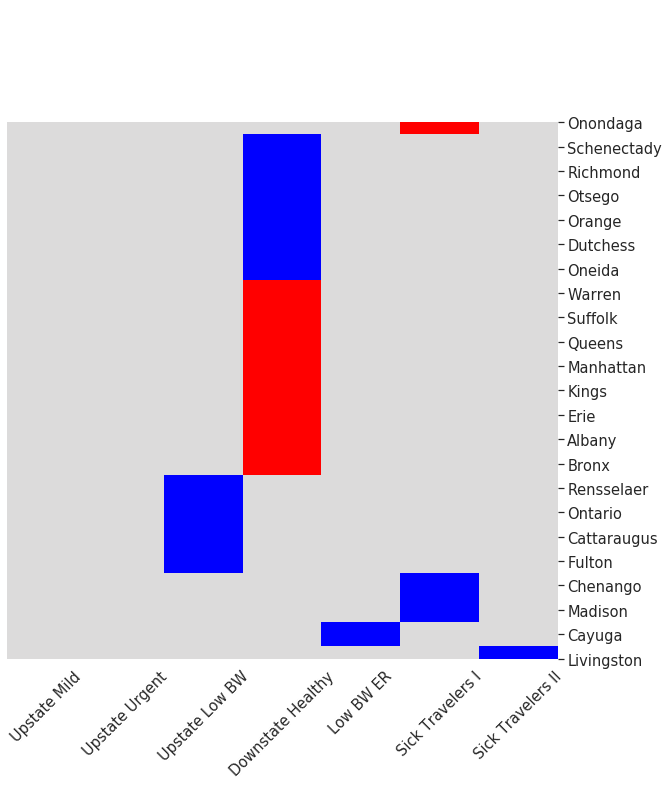

In [0]:
# county weights 
county_weights = filtered_weights[categories["County"],:]
# plot the clustermap of filtered  county weights 
plotclustmap((county_weights ) [np.sum(abs(county_weights),axis=1)>0,:],
             None, np.array(new_feat[8:58])[np.sum(abs(county_weights),axis=1)>0], None, None, 
             clust_name=clustname, cmap=mycmap)

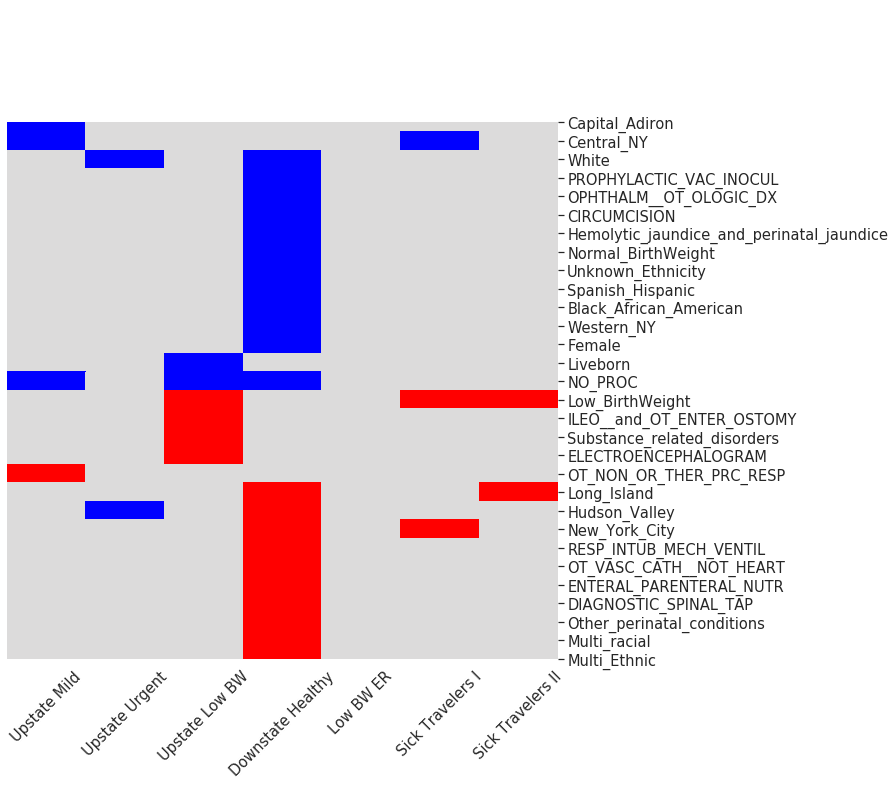

In [0]:
# noncounty weights 
noncounty_weights = filtered_weights[np.r_[0:8,58:259],:]
# plot the clustermap of filtered  noncounty weights 
plotclustmap((noncounty_weights ) [np.sum(abs(noncounty_weights),axis=1)>0,:], 
             None, np.array(new_feat)[np.r_[0:8,58:259]][np.sum(abs(noncounty_weights),axis=1)>0], None, None,
             clust_name=clustname, cmap=mycmap)

# Cross Validation

Here we perform several known classification methods for comparison with our proposed methods. 

## Nonclustering Classification

In [0]:
# Fitting a Bernoulli Naive Bayes
bnb = BernoulliNB(alpha= 1,class_prior=[0.75,0.25])
bnb.fit(Xtrain, ytrain)
probTrainNB,probTestNB = bnb.predict_proba(Xtrain)[:,1], bnb.predict_proba(Xtest)[:,1]
tau = optimalTau(probTrainNB, ytrain)
metTest,_ = calc_metrics(custom_prob = probTestNB.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNB.copy(), tau = tau, y = ytrain)
metTestNB = pd.DataFrame( [metTest], columns = columns)
metTrainNB = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#FITTING L1 LOGISTIC REGRESSION
Cs = [1,10,100,1000]
pL1, probTestL1, probTrainL1 = logisticRegressionCv2( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest, Cs = Cs )
tau = optimalTau(probTrainL1, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestL1.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainL1.copy(), tau = tau, y = ytrain)
metTestL1 = pd.DataFrame( [metTest], columns = columns)
metTrainL1 = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#Fitting Neural Nets
pNN, probTestNN, probTrainNN = neural_nets( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest,
                                                  h_l_s = (4 ,4, 2))
tau = optimalTau(probTrainNN, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestNN.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNN.copy(), tau = tau, y = ytrain)
metTestNN = pd.DataFrame( [metTest], columns = columns)
metTrainNN = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#RANDOM FORESTS
params, probTest, probTrain = randomforests(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestRF = pd.DataFrame( [metTest], columns = columns)
metTrainRF = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#Ada boost
params, probTest, probTrain = xboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestXB = pd.DataFrame( [metTest], columns = columns)
metTrainXB = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#Grad boost
params, probTest, probTrain = gradboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestGB = pd.DataFrame( [metTest], columns = columns)
metTrainGB = pd.DataFrame( [metTrain], columns = columns)

## Sequential Clustering + Classification

In [0]:
np.random.seed( seed = 0 )
#Kmeans + LG
n_clusters = 7

Cs = [1,10,100,1000]
kmeansParams = kmeansLogRegr(Xtrain = Xtrain, ytrain = ytrain, 
                             Xtest = Xtest, ytest = ytest, Cs = Cs, n_clusters = n_clusters)

modelsKM = kmeansParams['models']
labTrKM, labTestKM  = kmeansParams['labelsTrain'], kmeansParams['labelsTest']


# KMS class accuracy
metTrainKMc, metTestKMc = metrics_cluster(models = modelsKM, ytrain = ytrain,
                                        ytest = ytest, testlabels = labTestKM,
                                        trainlabels = labTrKM,
                                        Xtrain = Xtrain, Xtest = Xtest)

In [0]:
# KMS LG overall accuaracy
probTr= np.array([])
for i in range(len(kmeansParams['probTrain'])):
    probTr = np.append(probTr,kmeansParams['probTrain'][i])
yTr = np. array([])
for i in range(n_clusters):
    yTr = np.append(yTr,ytrain[labTrKM==i])

probTe= np.array([])
for i in range(len(kmeansParams['probTest'])):
    probTe = np.append(probTe,kmeansParams['probTest'][i])
yTe = np. array([])
for i in range(n_clusters):
    yTe = np.append(yTe,ytest[labTestKM==i])

tau = optimalTau(probTr, yTr)

metTrain ,__= calc_metrics(y = yTr, tau = tau, custom_prob = probTr)
metTest ,__= calc_metrics( y = yTe, tau = tau, custom_prob = probTe)
metTrainKMS = pd.DataFrame( [metTrain], columns = columns)
metTestKMS = pd.DataFrame( [metTest], columns = columns)

In [0]:
# Comparison acucuracy with other methods
trainmet = pd.concat([metTrainNB, metTrainL1,metTrainNN,metTrainRF,metTrainXB,metTrainGB, metTrainKMS,metTrainSGMM,metTrainSBMM],ignore_index=True)
testmet = pd.concat([metTestNB, metTestL1,metTestNN,metTestRF,metTestXB,metTestGB, metTestKMS,metTestSGMM,metTestSBMM],ignore_index=True)
method = ['Naive Bayes','L1 Log Reg','Neural Network','Random Forest','AdaBoost','GradBoost','KMS + Log Reg','SGMM w/ Log Reg', 'SBMM w/ Log Reg']
trainmet.insert(8,'method',method)
testmet.insert(8,'method',method)

# Overall prediction accuracy

In [0]:
testmet.iloc[:,8:].round(2)

Overall prediction accuracy


,method,FPR,specificity,sensitivity,precision,accuracy,balanced accuracy,f1,auc
0,Naive Bayes,0.19,0.81,0.58,0.50,0.75,0.70,0.54,0.78
1,L1 Log Reg,0.26,0.74,0.70,0.47,0.73,0.72,0.56,0.81
2,Neural Network,0.17,0.83,0.61,0.54,0.77,0.72,0.57,0.82
3,Random Forest,0.17,0.83,0.62,0.54,0.78,0.72,0.58,0.82
4,AdaBoost,0.26,0.74,0.71,0.47,0.73,0.72,0.56,0.81
5,GradBoost,0.23,0.77,0.67,0.49,0.74,0.72,0.57,0.81
6,KMS + Log Reg,0.22,0.78,0.65,0.50,0.75,0.72,0.56,0.81
7,SGMM w/ Log Reg,0.25,0.75,0.69,0.47,0.73,0.72,0.56,0.81
8,SBMM w/ Log Reg,0.18,0.82,0.59,0.52,0.77,0.71,0.55,0.81
